In [3]:
pip install gym pygame gym[other]

zsh:1: no matches found: gym[other]
Note: you may need to restart the kernel to use updated packages.


In [4]:
git clone https://github.com/tensorflow/tensorflow.git
cd tensorflow
./configure

SyntaxError: invalid syntax (3930454489.py, line 1)

In [ ]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Hiperparametreler
num_episodes = 100
eps = 1.0
eps_decay = 0.999
eps_min = 0.01

# Epsilon değerine dayalı olarak bir eylem seçer
def choose_action(state, eps):
    if np.random.uniform(0, 1) < eps:
        return env.action_space.sample()
    else:
        q_values = model.predict(state)
        return np.argmax(q_values[0])

# Gözlem verilerini modele uygun hale getirir
def get_state(observation):
    return np.array(observation).reshape(1, -1)

# OpenAI Gym'de CartPole oyununu başlat
env = gym.make('CartPole-v1')

# Modeli tanımla
model = Sequential()
model.add(Dense(64, input_shape=(4,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer=Adam(lr=0.001))

# Modeli eğit
for i in range(num_episodes):
    obs = env.reset()
    state = get_state(obs)
    done = False
    while not done:
        action = choose_action(state, eps)
        new_obs, reward, done, info = env.step(action)
        new_state = get_state(new_obs)
        target = model.predict(state)
        target[0][action] = reward + 0.95*np.max(model.predict(new_state)[0])
        model.fit(state, target, epochs=1, verbose=0)
        state = new_state
    eps = max(eps*eps_decay, eps_min)
    #print("Episode:", i+1, "Score:", info['score'])

# Modeli test et
obs = env.reset()
state = get_state(obs)
done = False
while not done:
    action = choose_action(state, eps_min)
    obs, reward, done, info = env.step(action)
    state = get_state(obs)
    env.render()


1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.9/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


error: ignored

In [ ]:
!ls

sample_data


In [ ]:
import time
import gym
import gym_cap
import gym_cap.heuristic as policy
import numpy as np
import torch
import configparser

def change_ini_settings(file_path, section, key, new_value):
    config = configparser.ConfigParser()
    config.read(file_path)
    original_value = config.get(section, key)
    config.set(section, key, new_value)

    with open(file_path, 'w') as config_file:
        config.write(config_file)
    return original_value




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("cap-v0")


output_file = open("results_1000_new.txt", "a")  # Metin dosyasını yazmak için dosya açılır
num_match = 1000
setting_file = 'setting.ini'

red_list=['Roomba'] #['Defense','Random','Zeros']
blue_list=['Defense','Patrol','Spiral','Random','Zeros']
values_to_change = {
    'elements': {
        'NUM_RED': '6',
        'NUM_RED_UAV': '3'
    },
    'settings': {
        'STOCH_TRANSITIONS': 'False',
        'STOCH_ATTACK': 'True'
    },
    'control': {
        'RED_ADV_BIAS': '2'
    },
    'memory': {
        'TEAM_MEMORY': 'fog',
        'INDIV_MEMORY': 'fog'
    },
    'communication': {
        'COM_GROUND': 'True',
        'COM_DISTANCE': '2'
    }
}

for section, key_value_dict in values_to_change.items():
    for key, new_value in key_value_dict.items():
        original_value = change_ini_settings(setting_file, section, key, new_value)

        output_file.write("time: " + time.ctime(time.time()) + " ( "+ key + " "+ original_value +" => "+ new_value +" )  \n")
        for bl in blue_list:
            for rl in red_list:
                observation = env.reset(
                                    map_size=20,
                                    config_path=setting_file,
                                    policy_red=getattr(policy, rl)(),
                                    policy_blue=getattr(policy, bl)() #policy.Fighter() # Defense Random Fighter Zeros Roomba Patrol Spiral Policy blue_policy
                                )
                action = env.action_space.sample()
                rscore = []
                start_time = time.time()

                for n in range(num_match):
                    done = False
                    rewards = []
                    while not done:
                        observation, reward, done, info = env.step(action)
                        rewards.append(reward)
                    env.reset()
                    rscore.append(sum(rewards))
                    duration = time.time() - start_time
                    #print("Time: %.2f s, Score: %.2f" % (duration, rscore[-1]))

                average_time = duration / num_match
                average_score = sum(rscore) / num_match
                print("red: "+rl+" blue: "+ bl+ " Average Time: %.2f s, Average Score: %.2f" % (duration/num_match, sum(rscore)/num_match))
                output_file.write("red: " + rl + " blue: " + bl + " Average Time: %.2f s, Average Score: %.2f\n" % (average_time, average_score))
        output_file.write("bitiş time: " + time.ctime(time.time()) + "\n")
        change_ini_settings(setting_file, section, key, original_value)


output_file.close()
env.close()

UnregisteredEnv: No registered env with id: cap-v0

Test with PPO model

In [3]:
import gymnasium as gym
import gym_cap  # gym_cap environment
from stable_baselines3 import PPO, DQN, A2C
import matplotlib.pyplot as plt
import numpy as np
import gym_cap.heuristic as policy

""" from gym import spaces
class Board(spaces.Space):
    
    def __init__(self, _shape=None, dtype=np.uint8):
        assert dtype is not None, 'dtype must be explicitly provided. '
        self.dtype = np.dtype(dtype)

        if _shape is None:
            self.shape = (20, 20, NUM_CHANNEL)
        else:
            assert _shape[2] == NUM_CHANNEL
            self.shape = tuple(_shape)
        super(Board, self).__init__(self.shape, self.dtype)

    def __repr__(self):
        return "Board" + str(self.shape)

    def sample(self):
        map_obj = [NUM_BLUE, NUM_BLUE_UAV, NUM_RED, NUM_RED_UAV, NUM_GRAY]
        state, _, _ = gen_random_map('map',
                self.shape[0], rand_zones=False, map_obj=map_obj)
        return state"""


class CompatibleEnv(gym.Wrapper):
    def reset(self, **kwargs):
        # Ensure seed is not passed if not handled by the environment
        kwargs.pop('seed', None)

        # Reset and manage all returned values appropriately
        output = self.env.reset(**kwargs)
        if isinstance(output, tuple):
            # Only return the observation (assuming it's the first item)
            return output[0]
        return output  # Return directly if not a tuple
# Wrap your environment
enva = CompatibleEnv(gym.make('cap-v0'))
# Ortamı oluşturun
env = gym.make('cap-v0')
envx = gym.make('CartPole-v1')

# PPO modelini oluşturun
model = PPO("MlpPolicy", env, verbose=1)

# Eğitim adımları ve kazanma oranlarını kaydetmek için değişkenler
num_games = 50  # Toplam oyun sayısı
timesteps_per_game = 1000  # Her oyun için zaman adımı
win_rates = []
#model.learn(total_timesteps=timesteps_per_game)

# Modeli eğitin ve kazanma oranlarını kaydedin
obs = env.reset(
                    map_size=20,
                    #config_path='/demo/base_setting.ini',
                    policy_red=getattr(policy, 'Roomba')(),
                    policy_blue=getattr(policy, 'Zeros')() #policy.Fighter() # Defense Random Fighter Zeros Roomba Patrol Spiral Policy blue_policy
                )
for game in range(num_games):
    model.learn(total_timesteps=timesteps_per_game)
    rewards = []
    # Kazanma oranını hesaplayın
    
    wins = 0
    for _ in range(timesteps_per_game):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(int(action))
        rewards.append(reward)
        if 'win' in info and info['win']:
            wins += 1
        if done:
            obs = env.reset()
    
    obs = env.reset()
    win_rate = sum(rewards) / timesteps_per_game  #wins
    win_rates.append(win_rate)
    print(f"Game {game + 1}/{num_games}: Win Rate = {win_rate:.2f}")

# Modeli kaydedin
model.save("ppo_ctf_model")

# Kazanma oranı grafiğini oluşturun
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_games + 1), win_rates, marker='o', linestyle='-', color='b')
plt.title('Win Rate per Game')
plt.xlabel('Game Number')
plt.ylabel('Win Rate')
plt.grid(True)
plt.show()

# Ortamı kapatın
env.close()


/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
Traceback (most recent

TypeError: reset() got an unexpected keyword argument 'seed'

In [ ]:
import gymnasium as gym
import gym_cap
import gym_cap.heuristic as policy
# Gym environment 'CartPole-v1' ile bir ortam oluşturuyoruz
env = gym.make('cap-v0')

# Ortamı başlat
#observation = env.reset()

# Toplam adım sayısı
total_steps = 1000
observation = env.reset(
                    map_size=20,
                    #config_path='/demo/base_setting.ini',
                    policy_red=getattr(policy, 'Roomba')(),
                    policy_blue=getattr(policy, 'Roomba')() #policy.Fighter() # Defense Random Fighter Zeros Roomba Patrol Spiral Policy blue_policy
                )
action = env.action_space.sample()
# Simülasyonu çalıştır
for step in range(total_steps):
    # Ortamı render et (opsiyonel)
    #action = env.action_space.sample()
    rewards = []
    done = False
    while not done:
        observation, reward, done, info = env.step(int(action))
        rewards.append(reward)
    env.reset()
    
    # Rastgele bir eylem seç
    #action = env.action_space.sample()
    
    # Eylemi gerçekleştirin ve yeni durumu alın
    #observation, reward, done, info = env.step(action)
    
    # Eğer epizot tamamlandıysa ortamı resetle
    if done:
        observation = env.reset()

# Ortamı kapat
env.close()

/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning:

Yeni bir mantık

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 575  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
Model 0 Total rewards: 0
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 740  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 4096 |
-----------------------------
Model 1 Total rewards: 0
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 740  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 6144 |
-----------------------------
Model 2 Total rewards: 0
Using cpu dev

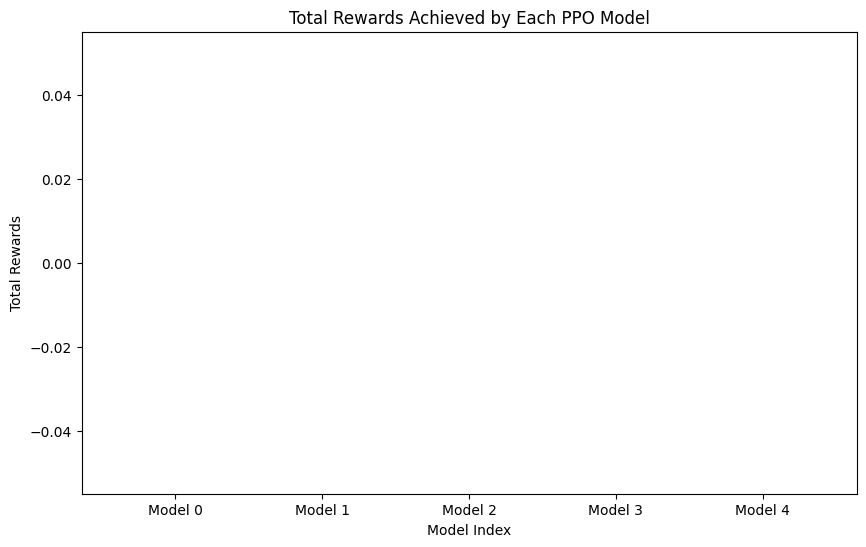

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO

# Custom environment class
class CaptureTheFlagEnv(gym.Env):
    def __init__(self):
        super(CaptureTheFlagEnv, self).__init__()
        self.action_space = spaces.MultiDiscrete([5, 5, 5, 5])
        self.observation_space = spaces.Dict({
            'team_1': spaces.Box(low=0, high=10, shape=(4, 2), dtype=np.float32),
            'team_2': spaces.Box(low=0, high=10, shape=(4, 2), dtype=np.float32),
            'flags': spaces.Box(low=0, high=10, shape=(2, 2), dtype=np.float32),
        })
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.team_1_pos = np.random.randint(0, 10, size=(4, 2))
        self.team_2_pos = np.random.randint(0, 10, size=(4, 2))
        self.flags_pos = np.random.randint(0, 10, size=(2, 2))
        return {
            'team_1': self.team_1_pos,
            'team_2': self.team_2_pos,
            'flags': self.flags_pos,
        }, {}

    def step(self, action):
        done = False
        reward = 0
        # Implement logic to update positions, check if flag is captured, calculate rewards, etc.

        # For demonstration, assume the episode ends after one step
        terminated = False  # Set to True if the episode has ended
        truncated = False   # Set to True if the episode was truncated (e.g., due to time limit)
        info = {}  # Additional info, can be left empty

        return {
            'team_1': self.team_1_pos,
            'team_2': self.team_2_pos,
            'flags': self.flags_pos,
        }, reward, terminated, truncated, info

    def render(self, mode='human'):
        pass

# Create environment
env = CaptureTheFlagEnv()

# Train and evaluate multiple PPO models
models = []
total_rewards_list = []
for i in range(5):
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048 * (i + 1))
    model.learn(total_timesteps=100)
    models.append(model)
    
    # Evaluate each model
    obs, _ = env.reset()
    total_rewards = 0
    for _ in range(100):
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_rewards += reward
        if terminated or truncated:
            break
    total_rewards_list.append(total_rewards)
    print(f"Model {i} Total rewards: {total_rewards}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(range(len(total_rewards_list)), total_rewards_list, color='skyblue')
plt.xlabel('Model Index')
plt.ylabel('Total Rewards')
plt.title('Total Rewards Achieved by Each PPO Model')
plt.xticks(range(len(total_rewards_list)), [f'Model {i}' for i in range(len(total_rewards_list))])
plt.show()


In [ ]:
Yeni Bir kütüphane Petting Zoo

In [ ]:
pip install pettingzoo matplotlib

In [ ]:
import matplotlib.pyplot as plt
from pettingzoo.atari import flag_capture_v2
import random

# Capture the Flag ortamını kuruyoruz
env = flag_capture_v2.env()

# Takım ve ajan bilgileri
teams = {'blue': 'defense', 'red': 'attack'}
agents = env.possible_agents  # Tüm ajanların listesini alır

# Ajanların takımlarını belirliyoruz
blue_team = [agent for agent in agents if 'blue' in agent]
red_team = [agent for agent in agents if 'red' in agent]

# Eğitim adım sayısı
steps = 1000

# Başarı sonuçlarını kaydedeceğimiz listeler
blue_team_rewards = []
red_team_rewards = []

# Ortamı sıfırlıyoruz
env.reset()

for step in range(steps):
    for agent in env.agent_iter():
        observation, reward, done, _, info = env.last()
        
        if agent in blue_team:
            # Mavi takım savunma stratejisi uyguluyor (rastgele hareket ediyor)
            action = random.choice([1, 2, 3, 4])  # Savunma pozisyonunda rastgele hareketler
        else:
            # Kırmızı takım saldırı stratejisi uyguluyor (rastgele hareket ediyor)
            action = random.choice([1, 2, 3, 4])  # Saldırı pozisyonunda rastgele hareketler
        env.step(action)
        
        # Ödülleri kaydediyoruz
        if agent in blue_team:
            blue_team_rewards.append(reward)
        else:
            red_team_rewards.append(reward)

    # Eğer tüm ajanlar done olduysa ortamı sıfırlıyoruz
    if all(env.dones.values()):
        env.reset()

# Sonuçları görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(range(len(blue_team_rewards)), blue_team_rewards, label='Blue Team (Defense)')
plt.plot(range(len(red_team_rewards)), red_team_rewards, label='Red Team (Attack)')
plt.xlabel('Steps')
plt.ylabel('Cumulative Rewards')
plt.title('Blue Team (Defense) vs Red Team (Attack) Performance')
plt.legend()
plt.show()


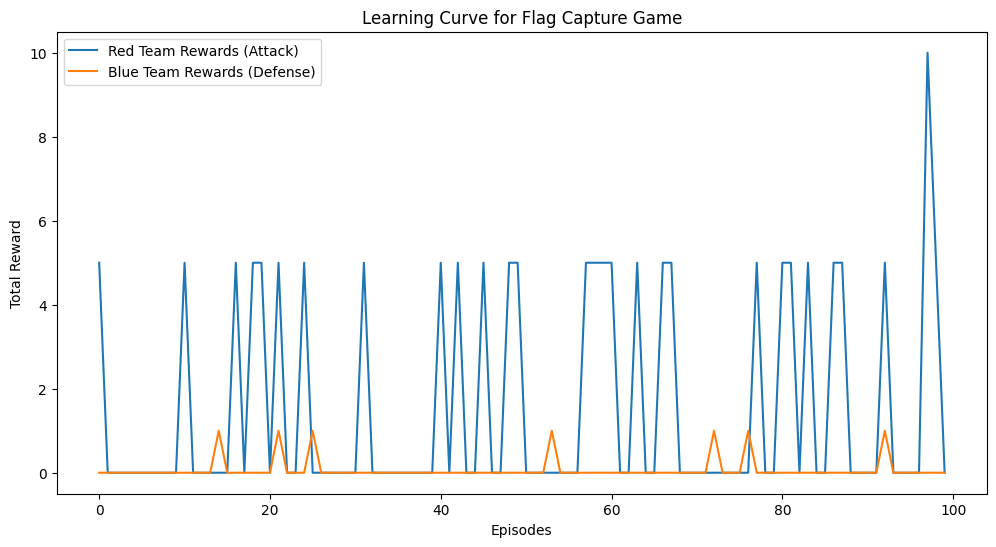

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import flag_capture_v2
from stable_baselines3 import PPO
from supersuit import pettingzoo_env_to_vec_env_v1, concat_vec_envs_v1
from stable_baselines3.common.vec_env import VecMonitor

# Oyun ortamını Gym uyumlu hale getir
env = flag_capture_v2.parallel_env()
env = pettingzoo_env_to_vec_env_v1(env)
env = concat_vec_envs_v1(env, 1, num_cpus=1, base_class='stable_baselines3')

# Ortamı izlemek için monitor ekleyelim
env = VecMonitor(env)

# Kırmızı takımın PPO modeli (saldırı)
red_team_model = PPO("CnnPolicy", env, verbose=0)
# Mavi takımın PPO modeli (savunma)
blue_team_model = PPO("CnnPolicy", env, verbose=0)

# Öğrenme eğrisi verileri
episodes = 100  # Episod sayısını 10'a düşürdük
max_steps = 1000 
red_team_rewards = []
blue_team_rewards = []

for episode in range(episodes):
    obs = env.reset()
    red_team_episode_reward = 0
    blue_team_episode_reward = 0
    done = [False] * env.num_envs

    #while not all(done):  # Döngüyü tüm ajanlar bitene kadar devam ettir
    for step in range(max_steps):
        # Kırmızı takım bayrağı kapmaya çalışır
        red_action = red_team_model.predict(obs[0])[0]  # 'first_0' yerine 0 indeksini kullanıyoruz
        # Mavi takım savunma yapar
        blue_action = blue_team_model.predict(obs[1])[0]  # 'second_0' yerine 1 indeksini kullanıyoruz

        actions = [red_action, blue_action]

        obs, rewards, done, infos = env.step(actions)
        
        red_team_episode_reward += rewards[0]  # 'first_0' yerine 0 indeksini kullanıyoruz
        blue_team_episode_reward += rewards[1]  # 'second_0' yerine 1 indeksini kullanıyoruz

    red_team_rewards.append(red_team_episode_reward)
    blue_team_rewards.append(blue_team_episode_reward)

# Öğrenme eğrisi grafiği
plt.figure(figsize=(12, 6))
plt.plot(red_team_rewards, label='Red Team Rewards (Attack)')
plt.plot(blue_team_rewards, label='Blue Team Rewards (Defense)')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Learning Curve for Flag Capture Game')
plt.legend()
plt.show()


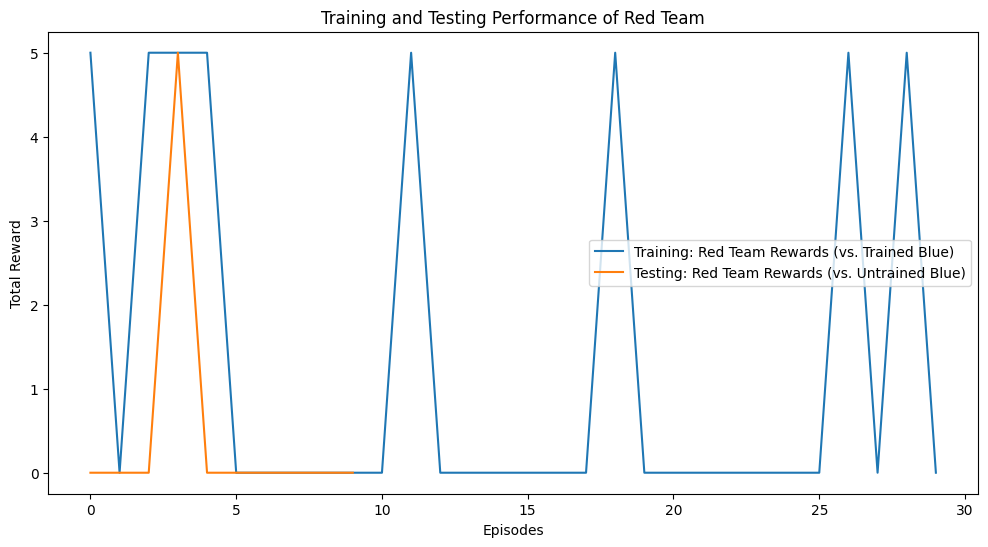

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import flag_capture_v2
from stable_baselines3 import PPO
from supersuit import pettingzoo_env_to_vec_env_v1, concat_vec_envs_v1
from stable_baselines3.common.vec_env import VecMonitor

# Oyun ortamını Gym uyumlu hale getir
env = flag_capture_v2.parallel_env()
env = pettingzoo_env_to_vec_env_v1(env)
env = concat_vec_envs_v1(env, 1, num_cpus=1, base_class='stable_baselines3')

# Ortamı izlemek için monitor ekleyelim
env = VecMonitor(env)

# Kırmızı takımın PPO modeli (saldırı)
red_team_model = PPO("CnnPolicy", env, verbose=0)
# Mavi takımın PPO modeli (savunma)
blue_team_model = PPO("CnnPolicy", env, verbose=0)

# Eğitim Süreci
episodes = 30  # Eğitim için toplam episode sayısı
max_steps = 500  # Her episode için maksimum adım sayısı
red_team_rewards = []
blue_team_rewards = []

for episode in range(episodes):
    obs = env.reset()
    red_team_episode_reward = 0
    blue_team_episode_reward = 0

    for step in range(max_steps):
        # Kırmızı takım bayrağı kapmaya çalışır
        red_action = red_team_model.predict(obs[0])[0]
        # Mavi takım savunma yapar (eğitilen model)
        blue_action = blue_team_model.predict(obs[1])[0]

        actions = [red_action, blue_action]

        obs, rewards, done, infos = env.step(actions)
        
        red_team_episode_reward += rewards[0]
        blue_team_episode_reward += rewards[1]

    red_team_rewards.append(red_team_episode_reward)
    blue_team_rewards.append(blue_team_episode_reward)

# Test Süreci (eğitilmemiş mavi takımla)
test_episodes = 10  # Test süreci için episode sayısı
test_red_team_rewards = []

for episode in range(test_episodes):
    obs = env.reset()
    red_team_episode_reward = 0

    for step in range(max_steps):
        # Kırmızı takım bayrağı kapmaya çalışır
        red_action = red_team_model.predict(obs[0])[0]
        # Mavi takım rastgele hareket eder (eğitilmemiş model)
        blue_action = env.action_space.sample()  # Rastgele bir aksiyon seçiliyor

        actions = [red_action, blue_action]

        obs, rewards, done, infos = env.step(actions)
        
        red_team_episode_reward += rewards[0]

    test_red_team_rewards.append(red_team_episode_reward)

# Eğitim ve Test Süreci Sonuçlarını Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(red_team_rewards, label='Training: Red Team Rewards (vs. Trained Blue)')
plt.plot(test_red_team_rewards, label='Testing: Red Team Rewards (vs. Untrained Blue)')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training and Testing Performance of Red Team')
plt.legend()
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import flag_capture_v2
from stable_baselines3 import PPO
from supersuit import pettingzoo_env_to_vec_env_v1, concat_vec_envs_v1
from stable_baselines3.common.vec_env import VecMonitor

# Oyun ortamını Gym uyumlu hale getir
env = flag_capture_v2.parallel_env()
env = pettingzoo_env_to_vec_env_v1(env)
env = concat_vec_envs_v1(env, 1, num_cpus=1, base_class='stable_baselines3')

# Ortamı izlemek için monitor ekleyelim
env = VecMonitor(env)

# Kırmızı takımın PPO modeli (saldırı)
red_team_model = PPO("CnnPolicy", env, verbose=0)
# Mavi takımın PPO modeli (savunma)
blue_team_model = PPO("CnnPolicy", env, verbose=0)

# Eğitim Süreci
episodes = 15  # Toplam episode sayısı
max_steps = 10000  # Her episode için maksimum adım sayısı
red_team_rewards = []
blue_team_rewards = []
test_rewards = []

for episode in range(episodes):
    obs = env.reset()
    red_team_episode_reward = 0
    blue_team_episode_reward = 0

    if (episode + 1) % 5 == 0:  # Her 5 episodda bir eğitilmemiş mavi takım ile savaş
        for step in range(max_steps):
            # Kırmızı takım bayrağı kapmaya çalışır
            red_action = red_team_model.predict(obs[0])[0]
            # Mavi takım rastgele hareket eder (eğitilmemiş model)
            blue_action = env.action_space.sample()

            actions = [red_action, blue_action]

            obs, rewards, done, infos = env.step(actions)
            
            red_team_episode_reward += rewards[0]

        test_rewards.append(red_team_episode_reward)  # Test sonuçlarını kaydet
        print(f"Test Episode {episode + 1}: Red Team Reward = {red_team_episode_reward}")
    else:
        for step in range(max_steps):
            # Kırmızı takım bayrağı kapmaya çalışır
            red_action = red_team_model.predict(obs[0])[0]
            # Mavi takım savunma yapar (eğitilen model)
            blue_action = blue_team_model.predict(obs[1])[0]

            actions = [red_action, blue_action]

            obs, rewards, done, infos = env.step(actions)
            if rewards[0]>0:
                print(rewards[0])
            red_team_episode_reward += rewards[0]
            blue_team_episode_reward += rewards[1]

        red_team_rewards.append(red_team_episode_reward)
        blue_team_rewards.append(blue_team_episode_reward)

# Eğitim ve Test Süreci Sonuçlarını Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(red_team_rewards) + 1), red_team_rewards, label='Training: Red Team Rewards (vs. Trained Blue)')
plt.plot(range(5, episodes + 1, 5), test_rewards, label='Testing: Red Team Rewards (vs. Untrained Blue)', marker='o')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training and Testing Performance of Red Team')
plt.legend()
plt.show()


/home/yonur/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


5.0
5.0
5.0
5.0
5.0
Test Episode 5: Red Team Reward = 0.0
5.0
5.0
5.0
Test Episode 10: Red Team Reward = 5.0
5.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import flag_capture_v2
from stable_baselines3 import PPO
from supersuit import pettingzoo_env_to_vec_env_v1, concat_vec_envs_v1
from stable_baselines3.common.vec_env import VecMonitor

# Oyun ortamını Gym uyumlu hale getir
env = flag_capture_v2.parallel_env()
env = pettingzoo_env_to_vec_env_v1(env)
env = concat_vec_envs_v1(env, 1, num_cpus=1, base_class='stable_baselines3')

# Ortamı izlemek için monitor ekleyelim
env = VecMonitor(env)

# Kırmızı takımın PPO modeli (saldırı)
red_team_model = PPO("CnnPolicy", env, verbose=0)
# Mavi takımın PPO modeli (savunma)
blue_team_model = PPO("CnnPolicy", env, verbose=0)

# Eğitim Süreci
episodes = 15  # Toplam episode sayısı
max_steps = 400  # Her episode için maksimum adım sayısı
red_team_rewards = []
blue_team_rewards = []
test_rewards = []

def is_near_opponent(red_pos, blue_pos):
    # Ajanların birbirine olan mesafesini kontrol eder
    return np.linalg.norm(np.array(red_pos) - np.array(blue_pos)) < 1.5

for episode in range(episodes):
    obs = env.reset()
    red_team_episode_reward = 0
    blue_team_episode_reward = 0

    if (episode + 1) % 5 == 0:  # Her 5 episodda bir eğitilmemiş mavi takım ile savaş
        for step in range(max_steps):
            # Kırmızı takım bayrağı kapmaya çalışır
            red_action = red_team_model.predict(obs[0])[0]
            # Mavi takım rastgele hareket eder (eğitilmemiş model)
            blue_action = env.action_space.sample()

            actions = [red_action, blue_action]

            obs, rewards, done, infos = env.step(actions)

            # Bayrağın güncel konumunu al
            flag_position = infos['flag_position']  # Ortamdan bayrak pozisyonunu çek

            # Ajanların pozisyon bilgilerini al
            red_pos = infos['player_red']['position']
            blue_pos = infos['player_blue']['position']

            # Bayrağa yakınlık ödülü
            red_distance_to_flag = np.linalg.norm(np.array(red_pos) - np.array(flag_position))
            blue_distance_to_flag = np.linalg.norm(np.array(blue_pos) - np.array(flag_position))

            # Bayrağa yeterince yakınsa ekstra ödül ver
            if red_distance_to_flag < 2.0:
                rewards[0] += 0.1  # Kırmızı takım ekstra ödül kazanır

            if blue_distance_to_flag < 2.0:
                rewards[1] += 0.1  # Mavi takım ekstra ödül kazanır

            # Rakibe yakın olma ödülü
            if is_near_opponent(red_pos, blue_pos):
                rewards[0] += 0.2  # Kırmızı takım ekstra ödül kazanır
                rewards[1] += 0.2  # Mavi takım da ödül kazanır

            # Ödülleri toplama
            red_team_episode_reward += rewards[0]

        test_rewards.append(red_team_episode_reward)  # Test sonuçlarını kaydet
        print(f"Test Episode {episode + 1}: Red Team Reward = {red_team_episode_reward}")
    else:
        for step in range(max_steps):
            # Kırmızı takım bayrağı kapmaya çalışır
            red_action = red_team_model.predict(obs[0])[0]
            # Mavi takım savunma yapar (eğitilen model)
            blue_action = blue_team_model.predict(obs[1])[0]

            actions = [red_action, blue_action]

            obs, rewards, done, infos = env.step(actions)

            # Bayrağın güncel konumunu al
            flag_position = infos['flag_position']  # Ortamdan bayrak pozisyonunu çek

            # Ajanların pozisyon bilgilerini al
            red_pos = infos['player_red']['position']
            blue_pos = infos['player_blue']['position']

            # Bayrağa yakınlık ödülü
            red_distance_to_flag = np.linalg.norm(np.array(red_pos) - np.array(flag_position))
            blue_distance_to_flag = np.linalg.norm(np.array(blue_pos) - np.array(flag_position))

            # Bayrağa yeterince yakınsa ekstra ödül ver
            if red_distance_to_flag < 2.0:
                rewards[0] += 0.1  # Kırmızı takım ekstra ödül kazanır

            if blue_distance_to_flag < 2.0:
                rewards[1] += 0.1  # Mavi takım ekstra ödül kazanır

            # Rakibe yakın olma ödülü
            if is_near_opponent(red_pos, blue_pos):
                rewards[0] += 0.2  # Kırmızı takım ekstra ödül kazanır
                rewards[1] += 0.2  # Mavi takım da ödül kazanır

            # Ödülleri toplama
            red_team_episode_reward += rewards[0]
            blue_team_episode_reward += rewards[1]

        red_team_rewards.append(red_team_episode_reward)
        blue_team_rewards.append(blue_team_episode_reward)

# Eğitim ve Test Süreci Sonuçlarını Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(red_team_rewards) + 1), red_team_rewards, label='Training: Red Team Rewards (vs. Trained Blue)')
plt.plot(range(5, episodes + 1, 5), test_rewards, label='Testing: Red Team Rewards (vs. Untrained Blue)', marker='o')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training and Testing Performance of Red Team')
plt.legend()
plt.show()


Yeni Kod

In [1]:
import torch
print(torch.cuda.is_available())  

True


In [3]:
import gym
from pettingzoo.atari import flag_capture_v2
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import numpy as np
from pettingzoo.utils.conversions import aec_to_parallel
from supersuit import pettingzoo_env_to_vec_env_v1

# Oyun ortamını oluştur ve AEC'den paralel ortama çevir
env = flag_capture_v2.env()  # AEC formatında başlatılıyor
env = aec_to_parallel(env)  # Paralel ortama çevir

# Gym ile uyumlu hale getir
env = pettingzoo_env_to_vec_env_v1(env)

# PPO modelini oluştur ve GPU kullanacak şekilde ayarla
model = PPO("CnnPolicy", env, verbose=1, device="cuda")  # GPU'yu kullanmak için device="cuda" eklendi

# Eğitimden önce kırmızı takımın başarısı
n_games = 100
red_wins_before = 0

for game in range(n_games):
    obs = env.reset()
    done = False
    while not done:
        # Tüm ajanların aksiyonları için rastgele örnekler alınır
        actions = np.array([env.action_space.sample() for _ in range(env.num_envs)])
        obs, rewards, dones,_, infos = env.step(actions)
        done = all(dones)
    if rewards[0] > rewards[1]:  # Kırmızı takımın kazanıp kazanmadığını kontrol et
        red_wins_before += 1

print(f"Red team wins before training: {red_wins_before}/{n_games}")

# Modeli eğit (GPU kullanımı ile)
model.learn(total_timesteps=1000000)

# Eğitimden sonra kırmızı takımın başarısı
red_wins_after = 0

for game in range(n_games):
    obs = env.reset()
    done = False
    while not done:
        actions = []
        for i in range(env.num_envs):
            action, _ = model.predict(obs[i])  # Modelden aksiyon tahmini al
            actions.append(action)
        actions = np.array(actions)
        obs, rewards, dones, infos = env.step(actions)
        done = all(dones)
    if rewards[0] > rewards[1]:  # Kırmızı takımın kazandığı oyunlar
        red_wins_after += 1

print(f"Red team wins after training: {red_wins_after}/{n_games}")

# Sonuçları görselleştir
labels = ['Before Training', 'After Training']
red_wins = [red_wins_before, red_wins_after]

plt.figure(figsize=(8, 6))
plt.bar(labels, red_wins, color=['blue', 'green'])
plt.ylabel('Red Team Wins')
plt.title('Red Team Wins Before and After Training')

# Grafiği kaydet
plt.savefig('red_team_wins_comparison.png')

# Grafiği göster
plt.show()


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


KeyboardInterrupt: 

In [4]:
import gym
from pettingzoo.atari import flag_capture_v2
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import numpy as np
from pettingzoo.utils.conversions import aec_to_parallel
from supersuit import pettingzoo_env_to_vec_env_v1, resize_v1, color_reduction_v0, frame_stack_v1

# Oyun ortamını oluştur ve AEC'den paralel ortama çevir
env = flag_capture_v2.env(render_mode="human")  # AEC formatında başlatılıyor
env = aec_to_parallel(env)  # Paralel ortama çevir

# Ortamın şekil boyutlarını küçült ve vektörleştirilmiş hale getir
#env = resize_v1(env, x_size=84, y_size=84)  # Gözlem boyutlarını düşürüyoruz
#env = color_reduction_v0(env, mode='full')  # Gözlemleri siyah-beyaza dönüştürüyoruz
#env = frame_stack_v1(env, 4)  # Gözlem geçmişini (frame stack) kullanarak 4 çerçeve saklıyoruz

# Gym ile uyumlu hale getir
env = pettingzoo_env_to_vec_env_v1(env)  # Ortamı vektörleştir

# PPO modelini oluştur ve GPU kullanacak şekilde ayarla
model = PPO("CnnPolicy", env, verbose=2, device="cuda",
            batch_size=64,  # Batch boyutunu artırın
            n_steps=128
            )  # GPU'yu kullanmak için device="cuda" eklendi

# Eğitimden önce kırmızı takımın başarısı
n_games = 1
red_wins_before = 0

model.learn(total_timesteps=1000000)

for game in range(n_games):
    obs = env.reset()  # Ortamı sıfırla
    dones = {agent: False for agent in env.par_env.possible_agents}  # Ajanlar için done durumu başlat
    
    while not all(dones.values()):  # Tüm ajanlar tamamlanmadıkça oyuna devam et
        actions = np.array([env.action_space.sample() for _ in range(env.num_envs)]) 
        

        # Aksiyonları uygula
        observations, rewards, terms, truncs, infos = env.step(actions)
        
        # Ajan başına oyunun bitip bitmediğini güncelle
        for i, agent in enumerate(env.par_env.possible_agents):
            dones[agent] = terms[i] or truncs[i]  # Ajan ya bitirmiştir ya da maksimum adıma ulaşmıştır
            
        if rewards[0] > rewards[1]:  # Kırmızı takımın kazanıp kazanmadığını kontrol et
            red_wins_before += 1

print(f"Red team wins before training: {red_wins_before}/{n_games}")

# Modeli eğit
model.learn(total_timesteps=1000000)

# Eğitimden sonra kırmızı takımın başarısı
red_wins_after = 0

for game in range(n_games):
    obs = env.reset()  # Ortamı sıfırla
    dones = {agent: False for agent in env.par_env.possible_agents}  # Ajanlar için done durumu başlat
    
    while not all(dones.values()):  # Tüm ajanlar tamamlanmadıkça oyuna devam et
        actions = {}
        for agent in env.par_env.possible_agents:
            if not dones[agent]:
                action, _ = model.predict(obs[agent])  # Modelden aksiyon tahmini al
                actions[agent] = action
        
        # Aksiyonların geçerli olduğundan emin ol
        for agent, action in actions.items():
            assert env.action_space.contains(action), f"Aksiyon {action} {agent} için geçerli değil."

        # Aksiyonları uygula
        observations, rewards, terms, truncs, infos = env.step(actions)
        
        # Ajan başına oyunun bitip bitmediğini güncelle
        for agent in env.par_env.possible_agents:
            dones[agent] = terms[agent] or truncs[agent]
            
        if rewards["red_0"] > rewards["blue_0"]:  # Kırmızı takımın kazanıp kazanmadığını kontrol et
            red_wins_after += 1

print(f"Red team wins after training: {red_wins_after}/{n_games}")

# Sonuçları görselleştir
labels = ['Before Training', 'After Training']
red_wins = [red_wins_before, red_wins_after]

plt.figure(figsize=(8, 6))
plt.bar(labels, red_wins, color=['blue', 'green'])
plt.ylabel('Red Team Wins')
plt.title('Red Team Wins Before and After Training')

# Grafiği kaydet
plt.savefig('red_team_wins_comparison.png')

# Grafiği göster
plt.show()


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


ValueError: could not broadcast input array from shape (2,210,160,3) into shape (210,160,3)

In [27]:
import gymnasium as gym
from pettingzoo.atari import flag_capture_v2
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import numpy as np
from pettingzoo.utils.conversions import aec_to_parallel
from supersuit import pettingzoo_env_to_vec_env_v1, resize_v1, color_reduction_v0, frame_stack_v1

# Oyun ortamını oluştur ve AEC'den paralel ortama çevir
env = flag_capture_v2.env(render_mode="human")  # AEC formatında başlatılıyor
env = aec_to_parallel(env)  # Paralel ortama çevir

# Ortamın şekil boyutlarını küçült ve vektörleştirilmiş hale getir
#env = resize_v1(env, x_size=84, y_size=84)  # Gözlem boyutlarını düşürüyoruz
#env = color_reduction_v0(env, mode='full')  # Gözlemleri siyah-beyaza dönüştürüyoruz
#env = frame_stack_v1(env, 4)  # Gözlem geçmişini (frame stack) kullanarak 4 çerçeve saklıyoruz

# Gym ile uyumlu hale getir
env = pettingzoo_env_to_vec_env_v1(env)  # Ortamı vektörleştir


class SingleAgentWrapper(gym.Wrapper):
    def __init__(self, env):
        super(SingleAgentWrapper, self).__init__(env)
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return obs[0], info  # Return the first agent's observation

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return obs[0], reward[0], done[0], info[0]  # Return data for the first agent

# Wrap the environment to handle single-agent observations
env = SingleAgentWrapper(env)


# PPO modelini oluştur ve GPU kullanacak şekilde ayarla
model = PPO("CnnPolicy", env, verbose=2, device="cuda",
            batch_size=64,  # Batch boyutunu artırın
            n_steps=128
            )  # GPU'yu kullanmak için device="cuda" eklendi

# Eğitimden önce kırmızı takımın başarısı
n_games = 1
red_wins_before = 0

model.learn(total_timesteps=10)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


TypeError: Unable to iterate over the following elements: 5

Kendi kodum

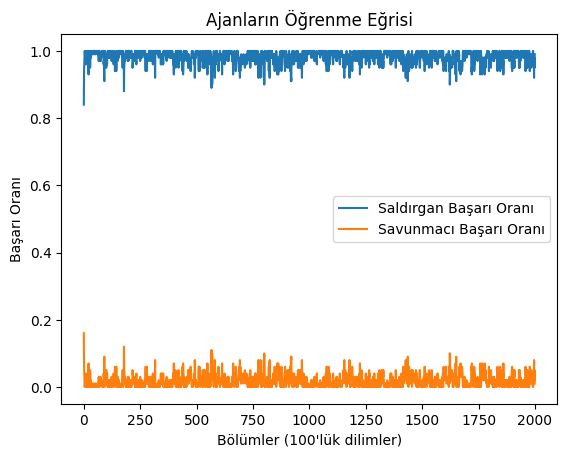

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Oyun ortamı sınıfı
class CaptureTheFlagEnv:
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.reset()

    # Ortamı sıfırla
    def reset(self):
        self.attacker_pos = [0, 0]  # Saldırgan başlangıç pozisyonu
        self.defender_pos = [self.grid_size - 1, self.grid_size - 1]  # Savunmacı başlangıç pozisyonu
        self.flag_pos = [self.grid_size - 1, 0]  # Bayrak pozisyonu
        return self.get_state()

    # Mevcut durumu al
    def get_state(self):
        return (tuple(self.attacker_pos), tuple(self.defender_pos))

    # Ajanları hareket ettir
    def step(self, attacker_action, defender_action):
        self.move(self.attacker_pos, attacker_action)
        self.move(self.defender_pos, defender_action)

        reward = 0
        done = False

        # Saldırgan bayrağa ulaştı mı?
        if self.attacker_pos == self.flag_pos:
            reward = 100  # Ödül
            done = True  # Oyun bitti

        # Savunmacı saldırganı yakaladı mı?
        elif self.attacker_pos == self.defender_pos:
            reward = -100  # Ceza
            done = True  # Oyun bitti
        else:
            # Her adımda küçük bir ceza ver
            reward = -1

        return self.get_state(), reward, done

    # Ajanı hareket ettir
    def move(self, position, action):
        if action == 0 and position[0] > 0:  # Yukarı
            position[0] -= 1
        elif action == 1 and position[0] < self.grid_size - 1:  # Aşağı
            position[0] += 1
        elif action == 2 and position[1] > 0:  # Sol
            position[1] -= 1
        elif action == 3 and position[1] < self.grid_size - 1:  # Sağ
            position[1] += 1
        # 4 ise bekle, hiçbir şey yapma

# Q-Öğrenme ajanı
class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.q_table = {}  # Q-değerleri tablosu
        self.actions = actions  # Eylem seti
        self.alpha = alpha  # Öğrenme hızı
        self.gamma = gamma  # İndirim faktörü
        self.epsilon = epsilon  # Keşif olasılığı

    # Eylem seç
    def choose_action(self, state):
        state = str(state)
        self.check_state_exist(state)
        if np.random.uniform(0, 1) < self.epsilon:
            # Rastgele eylem seç (keşif)
            action = np.random.choice(self.actions)
        else:
            # En iyi eylemi seç (sömürü)
            q_values = self.q_table[state]
            max_q = np.max(q_values)
            max_actions = [i for i, q in enumerate(q_values) if q == max_q]
            action = np.random.choice(max_actions)
        return action

    # Q-değerlerini güncelle
    def learn(self, s, a, r, s_):
        s, s_ = str(s), str(s_)
        self.check_state_exist(s)
        self.check_state_exist(s_)
        q_predict = self.q_table[s][a]
        if s_ != 'terminal':
            q_target = r + self.gamma * np.max(self.q_table[s_])
        else:
            q_target = r
        self.q_table[s][a] += self.alpha * (q_target - q_predict)

    # Durum Q-değerleri tablosunda yoksa ekle
    def check_state_exist(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(self.actions))

# Eğitim fonksiyonu
def train():
    env = CaptureTheFlagEnv()
    actions = [0, 1, 2, 3, 4]  # Yukarı, Aşağı, Sol, Sağ, Bekle

    attacker_agent = QLearningAgent(actions)
    defender_agent = QLearningAgent(actions)

    episodes = 200000
    attacker_success = []
    defender_success = []

    for episode in range(episodes):
        state = env.reset()
        total_attacker_reward = 0
        total_defender_reward = 0

        while True:
            attacker_action = attacker_agent.choose_action(state)
            defender_action = defender_agent.choose_action(state)

            next_state, reward, done = env.step(attacker_action, defender_action)

            if done:
                next_state_str = 'terminal'
            else:
                next_state_str = next_state

            # Ajanları eğit
            attacker_agent.learn(state, attacker_action, reward, next_state_str)
            defender_agent.learn(state, defender_action, -reward, next_state_str)

            state = next_state
            total_attacker_reward += reward
            total_defender_reward += -reward

            if done:
                if reward > 0:
                    attacker_success.append(1)
                    defender_success.append(0)
                elif reward < 0:
                    attacker_success.append(0)
                    defender_success.append(1)
                break

    # Başarı oranlarını hesapla (her 100 bölümde bir)
    window_size = 100
    attacker_win_rate = [np.mean(attacker_success[i:i+window_size]) for i in range(0, len(attacker_success), window_size)]
    defender_win_rate = [np.mean(defender_success[i:i+window_size]) for i in range(0, len(defender_success), window_size)]

    # Eğitim sonuçlarını grafikle
    plt.plot(attacker_win_rate, label='Saldırgan Başarı Oranı')
    plt.plot(defender_win_rate, label='Savunmacı Başarı Oranı')
    plt.xlabel('Bölümler (100\'lük dilimler)')
    plt.ylabel('Başarı Oranı')
    plt.title('Ajanların Öğrenme Eğrisi')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    train()


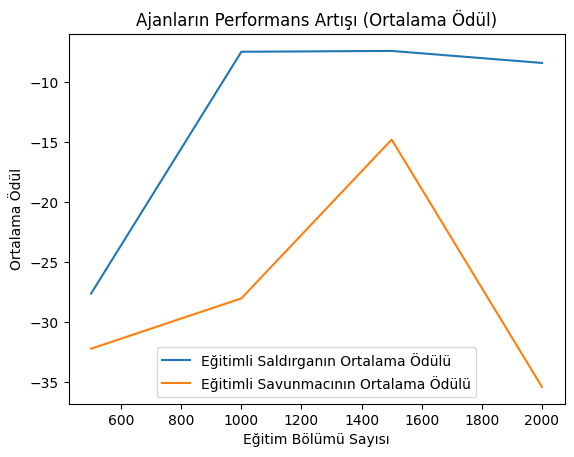

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random


# Oyun ortamı sınıfı
class CaptureTheFlagEnv:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    # Ortamı sıfırla
    def reset(self):
        self.attacker_pos = [0, random.randint(0, self.grid_size)]  # Saldırgan başlangıç pozisyonu
        self.defender_pos = [self.grid_size - 1, random.randint(0, self.grid_size)]  # Savunmacı başlangıç pozisyonu  self.grid_size - 1
        self.flag_pos = [random.randint(0, self.grid_size),random.randint(0, self.grid_size)]  # Bayrak pozisyonu random.randint(0, self.grid_size)
        return self.get_state()

    # Mevcut durumu al
    def get_state(self):
        return (tuple(self.attacker_pos), tuple(self.defender_pos), tuple(self.flag_pos) )

    # Ajanları hareket ettir
    def step(self, attacker_action, defender_action):
        prev_attacker_dist = self.get_distance(self.attacker_pos, self.flag_pos)
        prev_defender_dist = self.get_distance(self.defender_pos, self.attacker_pos)

        self.move(self.attacker_pos, attacker_action)
        self.move(self.defender_pos, defender_action)

        curr_attacker_dist = self.get_distance(self.attacker_pos, self.flag_pos)
        curr_defender_dist = self.get_distance(self.defender_pos, self.attacker_pos)

        reward = 0
        rreward = 0
        done = False

        # Saldırgan bayrağa ulaştı mı?
        if self.attacker_pos == self.flag_pos:
            reward = 20  # Ödül
            rreward = -5
            done = True  # Oyun bitti

        # Savunmacı saldırganı yakaladı mı?
        elif self.attacker_pos == self.defender_pos:
            reward = -5  # Ceza
            rreward = 20
            done = True  # Oyun bitti

            # Saldırganın bayrağa olan mesafesine göre ödül/ceza
        if curr_attacker_dist < prev_attacker_dist:
            rreward -= 1
            reward += 3  # Yaklaşıyor
        elif curr_attacker_dist > prev_attacker_dist:
            reward -= 2  # Uzaklaşıyor
        else:
            reward -= 1  # Mesafe aynı

        # Savunmacının saldırgana olan mesafesine göre ödül/ceza (tam tersi)
        if curr_defender_dist < prev_defender_dist:
            reward -= 1  # Savunmacı yaklaşıyor, saldırgan için ceza
            rreward += 3
        elif curr_defender_dist > prev_defender_dist:
            #reward += 1  # Savunmacı uzaklaşıyor, saldırgan için ödül
            rreward -= 2
        else:
            #reward += 1  # Mesafe aynı, saldırgan için küçük ödül
            rreward -= 1

        return self.get_state(), reward, rreward, done

    # Ajanı hareket ettir
    def move(self, position, action):
        if action == 0 and position[0] > 0:  # Yukarı
            position[0] -= 1
        elif action == 1 and position[0] < self.grid_size - 1:  # Aşağı
            position[0] += 1
        elif action == 2 and position[1] > 0:  # Sol
            position[1] -= 1
        elif action == 3 and position[1] < self.grid_size - 1:  # Sağ
            position[1] += 1
        # 4 ise bekle, hiçbir şey yapma

    # İki nokta arasındaki Manhattan mesafesini hesapla
    def get_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])        

# Q-Öğrenme ajanı
class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.q_table = {}  # Q-değerleri tablosu
        self.actions = actions  # Eylem seti
        self.alpha = alpha  # Öğrenme hızı
        self.gamma = gamma  # İndirim faktörü
        self.epsilon = epsilon  # Keşif olasılığı

    # Eylem seç
    def choose_action(self, state):
        state = str(state)
        self.check_state_exist(state)
        if np.random.uniform(0, 1) < self.epsilon:
            # Rastgele eylem seç (keşif)
            action = np.random.choice(self.actions)
        else:
            # En iyi eylemi seç (sömürü)
            q_values = self.q_table[state]
            max_q = np.max(q_values)
            max_actions = [i for i, q in enumerate(q_values) if q == max_q]
            action = np.random.choice(max_actions)
        return action

    # Q-değerlerini güncelle
    def learn(self, s, a, r, s_):
        s, s_ = str(s), str(s_)
        self.check_state_exist(s)
        if s_ != 'terminal':
            self.check_state_exist(s_)
            q_target = r + self.gamma * np.max(self.q_table[s_])
        else:
            q_target = r
        q_predict = self.q_table[s][a]
        self.q_table[s][a] += self.alpha * (q_target - q_predict)

    # Durum Q-değerleri tablosunda yoksa ekle
    def check_state_exist(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(self.actions))

# Rastgele ajan
class RandomAgent:
    def __init__(self, actions):
        self.actions = actions

    def choose_action(self, state):
        return np.random.choice(self.actions)

    def learn(self, s, a, r, s_):
        pass  # Rastgele ajan öğrenmez

# Eğitim ve test fonksiyonu
def train_and_test():
    env = CaptureTheFlagEnv()
    actions = [0, 1, 2, 3, 4]  # Yukarı, Aşağı, Sol, Sağ, Bekle

    # Eğitimli ajanlar
    attacker_agent = QLearningAgent(actions, 0.5)
    defender_agent = QLearningAgent(actions,0.5)

    # Eğitilmemiş (rastgele) ajanlar RandomAgent
    random_attacker = QLearningAgent(actions)
    random_defender = QLearningAgent(actions)

    total_episodes = 2000
    test_interval = 500
    test_episodes = 100

    intervals = []
    trained_attacker_avg_rewards = []
    random_attacker_avg_rewards = []

    # Eğitim ve periyodik test
    for episode in range(1, total_episodes + 1):
        state = env.reset()
        total_reward = 0
        while True:
            attacker_action = attacker_agent.choose_action(state)
            defender_action = defender_agent.choose_action(state)

            next_state, reward, rreward, done = env.step(attacker_action, defender_action)

            if done:
                next_state_str = 'terminal'
            else:
                next_state_str = next_state

            # Ajanları eğit
            attacker_agent.learn(state, attacker_action, reward, next_state_str)
            defender_agent.learn(state, defender_action, rreward, next_state_str)

            state = next_state
            total_reward += reward

            if done:
                break

        # Her test_interval bölümde bir test yap
        if episode % test_interval == 0:
            # Eğitimli saldırgan vs rastgele savunmacı
            trained_attacker_rewards = []
            for _ in range(test_episodes):
                state = env.reset()
                total_reward = 0
                while True:
                    attacker_action = attacker_agent.choose_action(state)
                    defender_action = random_defender.choose_action(state)

                    next_state, reward, rreward, done = env.step(attacker_action, defender_action)

                    state = next_state
                    total_reward += reward

                    if done:
                        trained_attacker_rewards.append(total_reward)
                        break

            # Rastgele saldırgan vs eğitimli savunmacı
            random_attacker_rewards = []
            for _ in range(test_episodes):
                state = env.reset()
                total_reward = 0
                while True:
                    attacker_action = random_attacker.choose_action(state)
                    defender_action = defender_agent.choose_action(state)

                    next_state, reward, rreward, done = env.step(attacker_action, defender_action)

                    state = next_state
                    total_reward += rreward

                    if done:
                        random_attacker_rewards.append(total_reward)
                        break

            # Ortalama ödülleri kaydet
            trained_avg_reward = np.mean(trained_attacker_rewards)
            random_avg_reward = np.mean(random_attacker_rewards)

            intervals.append(episode)
            trained_attacker_avg_rewards.append(trained_avg_reward)
            random_attacker_avg_rewards.append(random_avg_reward)

    # Sonuçları grafikle
    plt.plot(intervals, trained_attacker_avg_rewards, label='Eğitimli Saldırganın Ortalama Ödülü')
    plt.plot(intervals, random_attacker_avg_rewards, label='Eğitimli Savunmacının Ortalama Ödülü')
    plt.xlabel('Eğitim Bölümü Sayısı')
    plt.ylabel('Ortalama Ödül')
    plt.title('Ajanların Performans Artışı (Ortalama Ödül)')
    # Grafiği kaydet
    plt.savefig('manuel_code_2k.png')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    train_and_test()


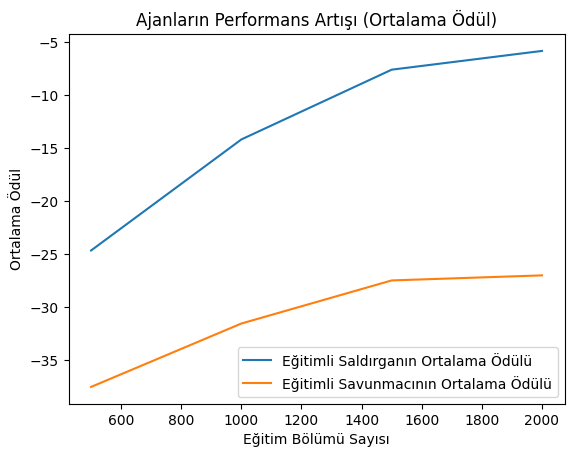

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random


# Oyun ortamı sınıfı
class CaptureTheFlagEnv:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    # Ortamı sıfırla
    def reset(self):
        self.attacker_pos = [0, random.randint(0, self.grid_size)]  # Saldırgan başlangıç pozisyonu
        self.defender_pos = [self.grid_size - 1, random.randint(0, self.grid_size)]  # Savunmacı başlangıç pozisyonu  self.grid_size - 1
        self.flag_pos = [random.randint(0, self.grid_size),random.randint(0, self.grid_size)]  # Bayrak pozisyonu random.randint(0, self.grid_size)
        return self.get_state()

    # Mevcut durumu al
    def get_state(self):
        return (tuple(self.attacker_pos), tuple(self.defender_pos), tuple(self.flag_pos) )

    # Ajanları hareket ettir
    def step(self, attacker_action, defender_action):
        prev_attacker_dist = self.get_distance(self.attacker_pos, self.flag_pos)
        prev_defender_dist = self.get_distance(self.defender_pos, self.attacker_pos)

        self.move(self.attacker_pos, attacker_action)
        self.move(self.defender_pos, defender_action)

        curr_attacker_dist = self.get_distance(self.attacker_pos, self.flag_pos)
        curr_defender_dist = self.get_distance(self.defender_pos, self.attacker_pos)

        reward = 0
        rreward = 0
        done = False

        # Saldırgan bayrağa ulaştı mı?
        if self.attacker_pos == self.flag_pos:
            reward = 20  # Ödül
            rreward = -5
            done = True  # Oyun bitti

        # Savunmacı saldırganı yakaladı mı?
        elif self.attacker_pos == self.defender_pos:
            reward = -5  # Ceza
            rreward = 20
            done = True  # Oyun bitti

            # Saldırganın bayrağa olan mesafesine göre ödül/ceza
        if curr_attacker_dist < prev_attacker_dist:
            rreward -= 1
            reward += 3  # Yaklaşıyor
        elif curr_attacker_dist > prev_attacker_dist:
            reward -= 2  # Uzaklaşıyor
        else:
            reward -= 1  # Mesafe aynı

        # Savunmacının saldırgana olan mesafesine göre ödül/ceza (tam tersi)
        if curr_defender_dist < prev_defender_dist:
            reward -= 1  # Savunmacı yaklaşıyor, saldırgan için ceza
            rreward += 3
        elif curr_defender_dist > prev_defender_dist:
            #reward += 1  # Savunmacı uzaklaşıyor, saldırgan için ödül
            rreward -= 2
        else:
            #reward += 1  # Mesafe aynı, saldırgan için küçük ödül
            rreward -= 1

        return self.get_state(), reward, rreward, done

    # Ajanı hareket ettir
    def move(self, position, action):
        if action == 0 and position[0] > 0:  # Yukarı
            position[0] -= 1
        elif action == 1 and position[0] < self.grid_size - 1:  # Aşağı
            position[0] += 1
        elif action == 2 and position[1] > 0:  # Sol
            position[1] -= 1
        elif action == 3 and position[1] < self.grid_size - 1:  # Sağ
            position[1] += 1
        # 4 ise bekle, hiçbir şey yapma

    # İki nokta arasındaki Manhattan mesafesini hesapla
    def get_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])        

# Q-Öğrenme ajanı
class QLearningAgent:
    def __init__(self, actions, alpha=0.2, gamma=0.9, epsilon=0.2):
        self.q_table = {}  # Q-değerleri tablosu
        self.actions = actions  # Eylem seti
        self.alpha = alpha  # Öğrenme hızı
        self.gamma = gamma  # İndirim faktörü
        self.epsilon = epsilon  # Keşif olasılığı

    # Eylem seç
    def choose_action(self, state):
        state = str(state)
        self.check_state_exist(state)
        if np.random.uniform(0, 1) < self.epsilon:
            # Rastgele eylem seç (keşif)
            action = np.random.choice(self.actions)
        else:
            # En iyi eylemi seç (sömürü)
            q_values = self.q_table[state]
            max_q = np.max(q_values)
            max_actions = [i for i, q in enumerate(q_values) if q == max_q]
            action = np.random.choice(max_actions)
        return action

    # Q-değerlerini güncelle
    def learn(self, s, a, r, s_):
        s, s_ = str(s), str(s_)
        self.check_state_exist(s)
        if s_ != 'terminal':
            self.check_state_exist(s_)
            q_target = r + self.gamma * np.max(self.q_table[s_])
        else:
            q_target = r
        q_predict = self.q_table[s][a]
        self.q_table[s][a] += self.alpha * (q_target - q_predict)

    # Durum Q-değerleri tablosunda yoksa ekle
    def check_state_exist(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(self.actions))

# Rastgele ajan
class RandomAgent:
    def __init__(self, actions):
        self.actions = actions

    def choose_action(self, state):
        return np.random.choice(self.actions)

    def learn(self, s, a, r, s_):
        pass  # Rastgele ajan öğrenmez

# Eğitim ve test fonksiyonu
def train_and_test():
    env = CaptureTheFlagEnv()
    actions = [0, 1, 2, 3, 4]  # Yukarı, Aşağı, Sol, Sağ, Bekle

    # Eğitimli ajanlar
    attacker_agent = QLearningAgent(actions )
    defender_agent = QLearningAgent(actions )

    # Eğitilmemiş (rastgele) ajanlar RandomAgent
    random_attacker = QLearningAgent(actions)
    random_defender = QLearningAgent(actions)

    total_episodes = 2000
    test_interval = 500
    test_episodes = 300

    intervals = []
    trained_attacker_avg_rewards = []
    random_attacker_avg_rewards = []

    # Eğitim ve periyodik test
    for episode in range(1, total_episodes + 1):
        state = env.reset()
        total_reward = 0
        while True:
            attacker_action = attacker_agent.choose_action(state)
            defender_action = defender_agent.choose_action(state)

            next_state, reward, rreward, done = env.step(attacker_action, defender_action)

            if done:
                next_state_str = 'terminal'
            else:
                next_state_str = next_state

            # Ajanları eğit
            attacker_agent.learn(state, attacker_action, reward, next_state_str)
            defender_agent.learn(state, defender_action, rreward, next_state_str)

            state = next_state
            total_reward += reward

            if done:
                break

        # Her test_interval bölümde bir test yap
        if episode % test_interval == 0:
            # Eğitimli saldırgan vs rastgele savunmacı
            trained_attacker_rewards = []
            for _ in range(test_episodes):
                state = env.reset()
                total_reward = 0
                while True:
                    attacker_action = attacker_agent.choose_action(state)
                    defender_action = random_defender.choose_action(state)

                    next_state, reward, rreward, done = env.step(attacker_action, defender_action)

                    state = next_state
                    total_reward += reward

                    if done:
                        trained_attacker_rewards.append(total_reward)
                        break

            # Rastgele saldırgan vs eğitimli savunmacı
            random_attacker_rewards = []
            for _ in range(test_episodes):
                state = env.reset()
                total_reward = 0
                while True:
                    attacker_action = random_attacker.choose_action(state)
                    defender_action = defender_agent.choose_action(state)

                    next_state, reward, rreward, done = env.step(attacker_action, defender_action)

                    state = next_state
                    total_reward += rreward

                    if done:
                        random_attacker_rewards.append(total_reward)
                        break

            # Ortalama ödülleri kaydet
            trained_avg_reward = np.mean(trained_attacker_rewards)
            random_avg_reward = np.mean(random_attacker_rewards)

            intervals.append(episode)
            trained_attacker_avg_rewards.append(trained_avg_reward)
            random_attacker_avg_rewards.append(random_avg_reward)

    # Sonuçları grafikle
    plt.plot(intervals, trained_attacker_avg_rewards, label='Eğitimli Saldırganın Ortalama Ödülü')
    plt.plot(intervals, random_attacker_avg_rewards, label='Eğitimli Savunmacının Ortalama Ödülü')
    plt.xlabel('Eğitim Bölümü Sayısı')
    plt.ylabel('Ortalama Ödül')
    plt.title('Ajanların Performans Artışı (Ortalama Ödül)')
    # Grafiği kaydet
    plt.savefig('manuel_code_2k.png')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    train_and_test()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict, deque

# Oyun ortamı sınıfı
class CaptureTheFlagEnv:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    # Ortamı sıfırla
    def reset(self):
        self.attacker_pos = [0, random.randint(0, self.grid_size - 1)]  # Saldırgan başlangıç pozisyonu
        self.defender_pos = [self.grid_size - 1, random.randint(0, self.grid_size - 1)]  # Savunmacı başlangıç pozisyonu
        self.flag_pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]  # Bayrak pozisyonu
        return self.get_state()

    # Mevcut durumu al
    def get_state(self):
        return (tuple(self.attacker_pos), tuple(self.defender_pos), tuple(self.flag_pos))

    # Ajanları hareket ettir
    def step(self, attacker_action, defender_action):
        prev_attacker_dist = self.get_distance(self.attacker_pos, self.flag_pos)
        prev_defender_dist = self.get_distance(self.defender_pos, self.attacker_pos)

        self.move(self.attacker_pos, attacker_action)
        self.move(self.defender_pos, defender_action)

        curr_attacker_dist = self.get_distance(self.attacker_pos, self.flag_pos)
        curr_defender_dist = self.get_distance(self.defender_pos, self.attacker_pos)

        reward = 0
        rreward = 0
        done = False

        # Saldırgan bayrağa ulaştı mı?
        if self.attacker_pos == self.flag_pos:
            reward = 20  # Ödül
            rreward = -5
            done = True  # Oyun bitti

        # Savunmacı saldırganı yakaladı mı?
        elif self.attacker_pos == self.defender_pos:
            reward = -5  # Ceza
            rreward = 20
            done = True  # Oyun bitti

        # Saldırganın bayrağa olan mesafesine göre ödül/ceza
        if curr_attacker_dist < prev_attacker_dist:
            rreward -= 1
            reward += 3  # Yaklaşıyor
        elif curr_attacker_dist > prev_attacker_dist:
            reward -= 2  # Uzaklaşıyor
        else:
            reward -= 1  # Mesafe aynı

        # Savunmacının saldırgana olan mesafesine göre ödül/ceza (tam tersi)
        if curr_defender_dist < prev_defender_dist:
            reward -= 1  # Savunmacı yaklaşıyor, saldırgan için ceza
            rreward += 3
        elif curr_defender_dist > prev_defender_dist:
            rreward -= 2
        else:
            rreward -= 1

        return self.get_state(), reward, rreward, done

    # Ajanı hareket ettir
    def move(self, position, action):
        if action == 0 and position[0] > 0:  # Yukarı
            position[0] -= 1
        elif action == 1 and position[0] < self.grid_size - 1:  # Aşağı
            position[0] += 1
        elif action == 2 and position[1] > 0:  # Sol
            position[1] -= 1
        elif action == 3 and position[1] < self.grid_size - 1:  # Sağ
            position[1] += 1
        # 4 ise bekle, hiçbir şey yapma

    # İki nokta arasındaki Manhattan mesafesini hesapla
    def get_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

# Temel Ajan Sınıfı
class BaseAgent:
    def choose_action(self, state):
        raise NotImplementedError

    def learn(self, *args):
        pass

    def check_state_exist(self, state):
        pass

# Q-Öğrenme ajanı
class QLearningAgent(BaseAgent):
    def __init__(self, actions, alpha=0.2, gamma=0.9, epsilon=0.2):
        self.q_table = {}  # Q-değerleri tablosu
        self.actions = actions  # Eylem seti
        self.alpha = alpha  # Öğrenme hızı
        self.gamma = gamma  # İndirim faktörü
        self.epsilon = epsilon  # Keşif olasılığı

    # Eylem seç
    def choose_action(self, state):
        state = str(state)
        self.check_state_exist(state)
        if np.random.uniform(0, 1) < self.epsilon:
            # Rastgele eylem seç (keşif)
            action = np.random.choice(self.actions)
        else:
            # En iyi eylemi seç (sömürü)
            q_values = self.q_table[state]
            max_q = np.max(q_values)
            max_actions = [i for i, q in enumerate(q_values) if q == max_q]
            action = np.random.choice(max_actions)
        return action

    # Q-değerlerini güncelle
    def learn(self, s, a, r, s_):
        s, s_ = str(s), str(s_)
        self.check_state_exist(s_)
        q_predict = self.q_table[s][a]
        if s_ != 'terminal':
            q_target = r + self.gamma * np.max(self.q_table[s_])  # Q-learning
        else:
            q_target = r  # Terminal state
        self.q_table[s][a] += self.alpha * (q_target - q_predict)  # Güncelleme

    # Durum Q-değerleri tablosunda yoksa ekle
    def check_state_exist(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(self.actions))

# SARSA ajanı
class SARSAAgent(BaseAgent):
    def __init__(self, actions, alpha=0.2, gamma=0.9, epsilon=0.2):
        self.q_table = {}
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, state):
        state = str(state)
        self.check_state_exist(state)
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            q_values = self.q_table[state]
            max_q = np.max(q_values)
            max_actions = [i for i, q in enumerate(q_values) if q == max_q]
            action = np.random.choice(max_actions)
        return action

    def learn(self, s, a, r, s_, a_):
        s, s_ = str(s), str(s_)
        self.check_state_exist(s_)
        q_predict = self.q_table[s][a]
        if s_ != 'terminal':
            q_target = r + self.gamma * self.q_table[s_][a_]  # SARSA
        else:
            q_target = r
        self.q_table[s][a] += self.alpha * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(self.actions))

# Double Q-Öğrenme ajanı
class DoubleQLearningAgent(BaseAgent):
    def __init__(self, actions, alpha=0.2, gamma=0.9, epsilon=0.2):
        self.q_table1 = {}
        self.q_table2 = {}
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, state):
        state = str(state)
        self.check_state_exist(state)
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            q_values = self.q_table1[state] + self.q_table2[state]
            max_q = np.max(q_values)
            max_actions = [i for i, q in enumerate(q_values) if q == max_q]
            action = np.random.choice(max_actions)
        return action

    def learn(self, s, a, r, s_):
        s, s_ = str(s), str(s_)
        self.check_state_exist(s_)
        if s_ != 'terminal':
            action = np.argmax(self.q_table1[s_])
            q_target = r + self.gamma * self.q_table2[s_][action]
        else:
            q_target = r
        if np.random.uniform(0, 1) < 0.5:
            self.q_table1[s][a] += self.alpha * (q_target - self.q_table1[s][a])
        else:
            self.q_table2[s][a] += self.alpha * (q_target - self.q_table2[s][a])

    def check_state_exist(self, state):
        if state not in self.q_table1:
            self.q_table1[state] = np.zeros(len(self.actions))
            self.q_table2[state] = np.zeros(len(self.actions))

# Expected SARSA ajanı
class ExpectedSARSAAgent(BaseAgent):
    def __init__(self, actions, alpha=0.2, gamma=0.9, epsilon=0.2):
        self.q_table = {}
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, state):
        state = str(state)
        self.check_state_exist(state)
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            q_values = self.q_table[state]
            max_q = np.max(q_values)
            max_actions = [i for i, q in enumerate(q_values) if q == max_q]
            action = np.random.choice(max_actions)
        return action

    def learn(self, s, a, r, s_):
        s, s_ = str(s), str(s_)
        self.check_state_exist(s_)
        q_predict = self.q_table[s][a]
        if s_ != 'terminal':
            # Hesaplanan beklenen Q değeri
            policy = np.ones(len(self.actions)) * self.epsilon / len(self.actions)
            best_action = np.argmax(self.q_table[s_])
            policy[best_action] += (1.0 - self.epsilon)
            expected_q = np.dot(self.q_table[s_], policy)
            q_target = r + self.gamma * expected_q
        else:
            q_target = r
        self.q_table[s][a] += self.alpha * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(self.actions))

# Monte Carlo ajanı
class MonteCarloAgent(BaseAgent):
    def __init__(self, actions, gamma=0.9, epsilon=0.2):
        self.Q = defaultdict(lambda: np.zeros(len(actions)))
        self.returns = defaultdict(lambda: defaultdict(list))
        self.actions = actions
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, state):
        state = str(state)
        if state not in self.Q:
            self.Q[state] = np.zeros(len(self.actions))
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.actions)
        else:
            max_q = np.max(self.Q[state])
            max_actions = [i for i, q in enumerate(self.Q[state]) if q == max_q]
            return np.random.choice(max_actions)

    def learn(self, episodes):
        for episode in episodes:
            G = 0
            visited = set()
            for step in reversed(episode):
                state, action, reward = step
                G = self.gamma * G + reward
                if (state, action) not in visited:
                    self.returns[state][action].append(G)
                    self.Q[state][action] = np.mean(self.returns[state][action])
                    visited.add((state, action))

# Dyna-Q ajanı
class DynaQAgent(BaseAgent):
    def __init__(self, actions, alpha=0.2, gamma=0.9, epsilon=0.2, planning_steps=5):
        self.q_table = {}
        self.model = {}
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_steps = planning_steps

    def choose_action(self, state):
        state = str(state)
        self.check_state_exist(state)
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            q_values = self.q_table[state]
            max_q = np.max(q_values)
            max_actions = [i for i, q in enumerate(q_values) if q == max_q]
            action = np.random.choice(max_actions)
        return action

    def learn(self, s, a, r, s_):
        s, s_ = str(s), str(s_)
        self.check_state_exist(s_)
        # Güncelleme
        q_predict = self.q_table[s][a]
        if s_ != 'terminal':
            q_target = r + self.gamma * np.max(self.q_table[s_])
        else:
            q_target = r
        self.q_table[s][a] += self.alpha * (q_target - q_predict)
        # Modeli güncelle
        self.model[(s, a)] = (r, s_)
        # Planlama
        for _ in range(self.planning_steps):
            (state_p, action_p), (reward_p, next_state_p) = random.choice(list(self.model.items()))
            self.check_state_exist(next_state_p)
            if next_state_p != 'terminal':
                q_target_p = reward_p + self.gamma * np.max(self.q_table[next_state_p])
            else:
                q_target_p = reward_p
            self.q_table[state_p][action_p] += self.alpha * (q_target_p - self.q_table[state_p][action_p])

    def check_state_exist(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(len(self.actions))

# Rastgele ajan (Önceden tanımlı)
class RandomAgent(BaseAgent):
    def __init__(self, actions):
        self.actions = actions

    def choose_action(self, state):
        return np.random.choice(self.actions)

    def learn(self, s, a, r, s_):
        pass  # Rastgele ajan öğrenmez

# Eğitim ve test fonksiyonu
def train_and_test():
    env = CaptureTheFlagEnv()
    actions = [0, 1, 2, 3, 4]  # Yukarı, Aşağı, Sol, Sağ, Bekle

    # Ajan modelleri
    agent_models = {
        'Q-Learning': QLearningAgent(actions),
        'SARSA': SARSAAgent(actions),
        'Double Q-Learning': DoubleQLearningAgent(actions),
        'Expected SARSA': ExpectedSARSAAgent(actions),
        'Monte Carlo': MonteCarloAgent(actions),
        'Dyna-Q': DynaQAgent(actions)
    }

    # Rastgele ajanlar
    random_attacker = RandomAgent(actions)
    random_defender = RandomAgent(actions)

    total_episodes = 20000
    test_interval = 500
    test_episodes = 300

    # Sonuçları saklamak için
    results = {model: {'trained_attacker': [], 'trained_defender': []} for model in agent_models.keys()}

    # Eğitim ve periyodik test
    for episode in range(1, total_episodes + 1):
        state = env.reset()
        # Her model için ayrı eğitim
        for model_name, agent in agent_models.items():
            done = False
            while not done:
                # Ajan eylem seçimi
                attacker_action = agent.choose_action(state)
                defender_action = agent_models[model_name].choose_action(state)  # Aynı modelden defender

                next_state, reward, rreward, done = env.step(attacker_action, defender_action)

                if done:
                    next_state_str = 'terminal'
                else:
                    next_state_str = next_state

                # Ajanı eğit
                if model_name == 'SARSA':
                    # SARSA için sonraki eylemi de seçmek gerekiyor
                    next_action = agent.choose_action(next_state)
                    agent.learn(state, attacker_action, reward, next_state, next_action)
                elif model_name == 'Monte Carlo':
                    # Monte Carlo için episodic yaklaşımlar gerek
                    # Burada basit bir yaklaşım kullanılabilir
                    pass  # Detaylı implementasyon gerekli
                else:
                    agent.learn(state, attacker_action, reward, next_state_str)

                state = next_state

        # Her test_interval bölümde bir test yap
        if episode % test_interval == 0:
            for model_name, agent in agent_models.items():
                # Eğitimli saldırgan vs rastgele savunmacı
                trained_attacker_rewards = []
                for _ in range(test_episodes):
                    state = env.reset()
                    total_reward = 0
                    while True:
                        attacker_action = agent.choose_action(state)
                        defender_action = random_defender.choose_action(state)

                        next_state, reward, rreward, done = env.step(attacker_action, defender_action)

                        state = next_state
                        total_reward += reward

                        if done:
                            trained_attacker_rewards.append(total_reward)
                            break

                # Rastgele saldırgan vs eğitimli savunmacı
                trained_defender_rewards = []
                for _ in range(test_episodes):
                    state = env.reset()
                    total_reward = 0
                    while True:
                        attacker_action = random_attacker.choose_action(state)
                        defender_action = agent.choose_action(state)

                        next_state, reward, rreward, done = env.step(attacker_action, defender_action)

                        state = next_state
                        total_reward += rreward

                        if done:
                            trained_defender_rewards.append(total_reward)
                            break

                # Ortalama ödülleri kaydet
                trained_avg_reward = np.mean(trained_attacker_rewards)
                trained_defender_avg_reward = np.mean(trained_defender_rewards)

                results[model_name]['trained_attacker'].append(trained_avg_reward)
                results[model_name]['trained_defender'].append(trained_defender_avg_reward)

            print(f"Episode {episode} completed and tested.")

    # Sonuçları grafikle
    plt.figure(figsize=(14, 6))

    # Eğitimli saldırganlar
    plt.subplot(1, 2, 1)
    for model_name in agent_models.keys():
        plt.plot(range(test_interval, total_episodes + 1, test_interval),
                 results[model_name]['trained_attacker'],
                 label=f'{model_name} Attacker')
    plt.xlabel('Eğitim Bölümü Sayısı')
    plt.ylabel('Ortalama Ödül (Saldırgan)')
    plt.title('Eğitimli Saldırganların Performansı')
    plt.legend()

    # Eğitimli savunmacılar
    plt.subplot(1, 2, 2)
    for model_name in agent_models.keys():
        plt.plot(range(test_interval, total_episodes + 1, test_interval),
                 results[model_name]['trained_defender'],
                 label=f'{model_name} Defender')
    plt.xlabel('Eğitim Bölümü Sayısı')
    plt.ylabel('Ortalama Ödül (Savunmacı)')
    plt.title('Eğitimli Savunmacıların Performansı')
    plt.legend()

    plt.tight_layout()
    # Grafiği kaydet
    plt.savefig('agent_performance_comparison.png')
    plt.show()

if __name__ == "__main__":
    train_and_test()


Episode 500 completed and tested.
Episode 1000 completed and tested.
